In [7]:
!pip install pafy youtube-dl moviepy

     |████████████████████████████████| 1.9 MB 6.1 MB/s            


# Imports

In [8]:
import os 
import cv2
import pafy
import math
import random
import numpy as np
import datetime as df
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [9]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

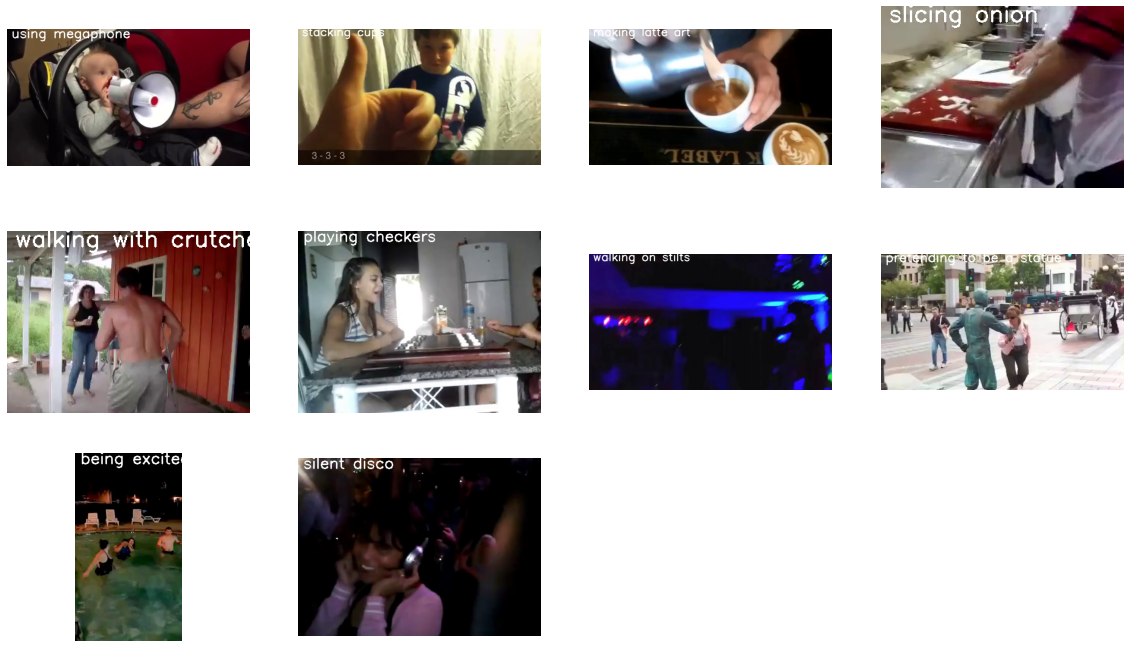

In [72]:
plt.figure(figsize =(20,20))


all_classes_names = os.listdir("/Users/philkolling/Downloads/EditedVideos/")

random_range = random.sample(range(len(all_classes_names)),10)


for counter, random_index in enumerate(random_range,1):
    
    selected_class_Name = all_classes_names[random_index]
    
    video_files_names_list = os.listdir(f"/Users/philkolling/Downloads/EditedVideos/{selected_class_Name}")
    
    selected_video_file_name = random.choice(video_files_names_list)
    
    video_reader = cv2.VideoCapture(f"/Users/philkolling/Downloads/EditedVideos/{selected_class_Name}/{selected_video_file_name}")
    
    _, bgr_frame = video_reader.read()
    
    video_reader.release()
    
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
    cv2.putText(rgb_frame, selected_class_Name, (10,20), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    
    plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis("off")
    
    

# Preprocess Data

In [59]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 10

DATASET_DIR = "/Users/philkolling/Downloads/EditedVideos/"

CLASSES_LIST = ['silent disco', 'being excited','walking on stilts',
       'pretending to be a statue', 'walking with crutches',
       'slicing onion', 'stacking cups', 'making latte art',
       'playing checkers', 'using megaphone']

In [74]:
def frames_extraction(video_path):    
    frames_list = []

    video_reader = cv2.VideoCapture(video_path) 

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),10)
    skip_frames_window = 1 
    for frame_counter in range(SEQUENCE_LENGTH):
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read()
        
        if not success:
            break
            
        resized_frame = cv2.resize(frame,(IMAGE_HEIGHT, IMAGE_WIDTH))
        
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
        
    video_reader.release()
    
    return frames_list

In [76]:
def create_dataset():
    
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print (f"extracting Data of Class: {class_name}")
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            frames = frames_extraction(video_file_path)
            
            if len(frames) == SEQUENCE_LENGTH:
                
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, labels, video_files_paths    

In [77]:
features, labels, video_files_paths = create_dataset()

extracting Data of Class: silent disco
extracting Data of Class: being excited
extracting Data of Class: walking on stilts
extracting Data of Class: pretending to be a statue
extracting Data of Class: walking with crutches
extracting Data of Class: slicing onion
extracting Data of Class: stacking cups
extracting Data of Class: making latte art
extracting Data of Class: playing checkers
extracting Data of Class: using megaphone


In [79]:
len(features)

352

In [53]:
#try it without if it takes to long

one_hot_ecoded_labels = to_categorical(labels)

# Base Model

In [43]:
#features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_ecoded_labels,
#                                                                            test_size=0.25, shuffle=True,
 #                                                                          random_state= seed_constant)